# Arithmetic trends impact of fires: 

Removes the extreme B.B. evets from the data set to see the impact

***Figure S16:*** 

In [1]:
import sys

script_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts'

sys.path.append(script_path+'\\Extremes')
import extremes_functions as extremes
sys.path.append(script_path+'\\functions_backtrajectories')
import functions_backtrajectories as fu_backtraj
sys.path.append(script_path+'\\Trends')
import trends_functions as fu_trends

%load_ext autoreload
%autoreload 2

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.gridspec as gridspec

In [2]:
savepath = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

In [3]:
df_abs637 = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended',                   
                       filename='oldpsap_newpsap_maap',)

df_era5_GDAS = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')

df = pd.merge(df_abs637, df_era5_GDAS, left_index=True, right_index=True)

df_GFED = extremes.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\GFED',                   
                       filename='GFED',)

df_ECLIPSE = extremes.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ECLIPSE',
              filename='ECLIPSE')

var_rain = 'tp_era5'
var_fire = 'BC_GFED'

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\GFED\GFED.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ECLIPSE\ECLIPSE.dat


In [4]:
def clean_with_25_rule(df, var):
    print("lenght before cleaning: "+str(len(df)))
    month_counts = df.groupby('month_ordinal').count()[var]
    month_counts = month_counts/(24*30)
    below = month_counts[month_counts < 0.25]
    below_25 = below.index

    df_ = df[~df['month_ordinal'].isin(below_25)]

    month_counts = df_.groupby('month_ordinal').count()[var]
    month_counts = month_counts/(24*30)

    fig, ax = plt.subplots(figsize=(5,2))
    ax.plot(month_counts.index, month_counts.values)
    plt.show()

    season_counts = df_.groupby('season_ordinal').count()[var]
    season_counts = season_counts/(24*30*4)

    fig, ax = plt.subplots(figsize=(5,2))
    ax.plot(season_counts.index, season_counts.values)
    plt.show()

    season_below = season_counts[season_counts < 0.25]
    season_below_25 = season_below.index
    df__ = df_[~df_['season_ordinal'].isin(season_below_25)]

    season_counts = df__.groupby('season_ordinal').count()[var]
    season_counts = season_counts/(24*30*4)

    fig, ax = plt.subplots(figsize=(5,2))
    ax.plot(season_counts.index, season_counts.values)
    plt.show()
    print("lenght after cleaning: "+str(len(df__)))
    return  df__

In [5]:
df_rain, df_rain_D = extremes.add_datetime_columns_and_resample_D(df_era5_GDAS, resample=True)
df_abs, df_abs_D = extremes.add_datetime_columns_and_resample_D(df_abs637, resample=True)
df_fire, df_fire_D = extremes.add_datetime_columns_and_resample_D(df_GFED, resample=True)

lenght before cleaning: 157263


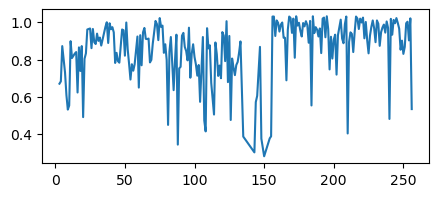

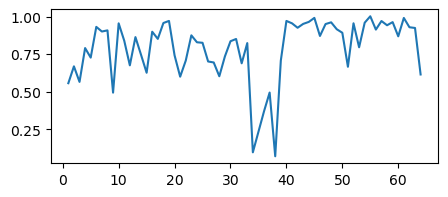

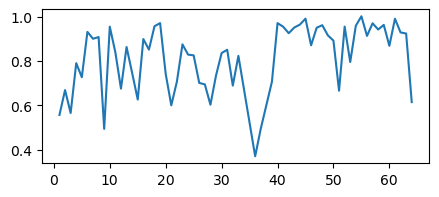

lenght after cleaning: 155097


In [6]:
df_abs = clean_with_25_rule(df_abs, var='abs637')

lenght before cleaning: 142562


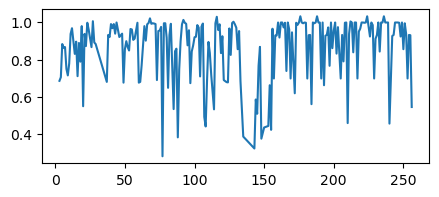

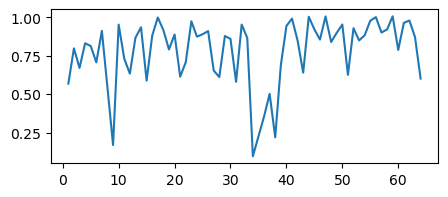

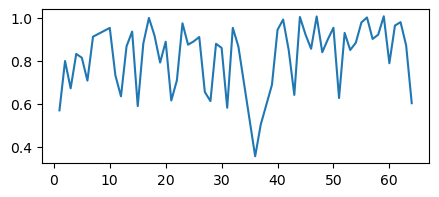

lenght after cleaning: 140029


In [7]:
df_rain = clean_with_25_rule(df_rain, var='tp_era5')

lenght before cleaning: 143493


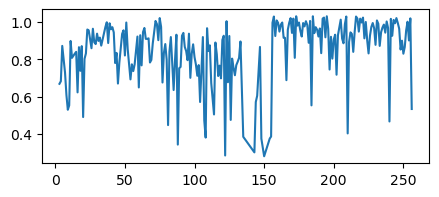

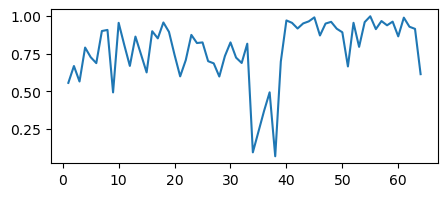

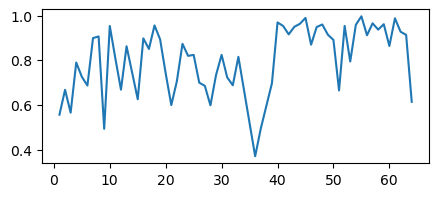

lenght after cleaning: 141753


In [8]:
df_fire = clean_with_25_rule(df_fire, var=var_fire)

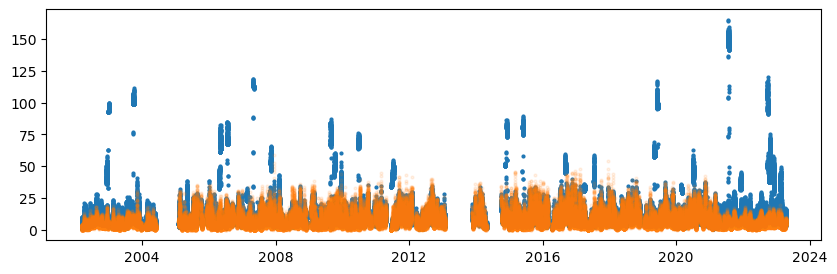

In [9]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df_rain.index, df_rain['tp_era5'], 'o', ms=2)
ax.plot(df_rain.index, df_rain['RAINFALL'], 'o', ms=2, alpha=.1)
plt.show()

In [10]:
df_DOY_50_abs, df_percentile_DOY_95_abs, df_DOY_95_abs, df_DOY_99_abs, df_DOY_01_abs = extremes.produce_differeent_rolling_quantiles(df_abs, var='abs637')
df_DOY_50_rain, df_percentile_DOY_95_rain, df_DOY_95_rain, df_DOY_99_rain, df_DOY_01_rain = extremes.produce_differeent_rolling_quantiles(df_rain, 
                                                                                                                                var=var_rain)
df_DOY_50_fire, df_percentile_DOY_95_fire, df_DOY_95_fire, df_DOY_99_fire, df_DOY_01_fire = extremes.produce_differeent_rolling_quantiles(df_fire, 
                                                                                                                                var=var_fire)

In [11]:
def produce_differeent_rolling_quantiles(df, var='abs637'):
    df_DOY_50 = calculate_rolling_quantile(df, var=var, quantile=.5, window=24*15)[1]
    df_percentile_DOY_95, df_DOY_95 = calculate_rolling_quantile(df, var=var, quantile=.95, window=24*15)
    df_DOY_99 = calculate_rolling_quantile(df, var=var, quantile=.99, window=24*15)[1]
    df_DOY_01 = calculate_rolling_quantile(df, var=var, quantile=.01, window=24*15)[1]
    return df_DOY_50, df_percentile_DOY_95, df_DOY_95, df_DOY_99, df_DOY_01

In [12]:
def create_df_of_percentiles(df, top_percentiles=[99,98,97,96,95,90,80,70,60,50],  var='abs637'):
    df_percentiles = pd.DataFrame()
    bottom_percentiles = [100-x for x in top_percentiles]
    percentiles = top_percentiles + bottom_percentiles 
    for percentile in percentiles:
        df_rolling, df_percentile_DOY = extremes.calculate_rolling_quantile(df, var, quantile=percentile/100, window=24*15)
        df_percentiles['percentile_'+str(percentile)] = df_percentile_DOY[var]
    return df_percentiles

def quantiles_df(df, df_percentiles, var, percentile):
    print(df_percentiles.columns)       
    df_DOY_top = df_percentiles[['percentile_'+str(percentile)]].copy()
    df_DOY_top = df_DOY_top.rename(columns={'percentile_'+str(percentile):str(var)+'_DOY_quantile_top'})    
    df_DOY_bottom = df_percentiles[['percentile_'+str(100-percentile)]].copy()
    df_DOY_bottom = df_DOY_bottom.rename(columns={'percentile_'+str(100-percentile):str(var)+'_DOY_quantile_bottom'})    
    df = pd.merge(df, df_DOY_top[[str(var)+'_DOY_quantile_top']], on='DOY')    
    df = pd.merge(df, df_DOY_bottom[[str(var)+'_DOY_quantile_bottom']], on='DOY')
    return df

Index(['percentile_99', 'percentile_98', 'percentile_97', 'percentile_96',
       'percentile_95', 'percentile_90', 'percentile_80', 'percentile_70',
       'percentile_60', 'percentile_50', 'percentile_1', 'percentile_2',
       'percentile_3', 'percentile_4', 'percentile_5', 'percentile_10',
       'percentile_20', 'percentile_30', 'percentile_40'],
      dtype='object')
High outliers (proportion)
0.06647463166797021
Low outliers (proportion)
0.015311929697385908


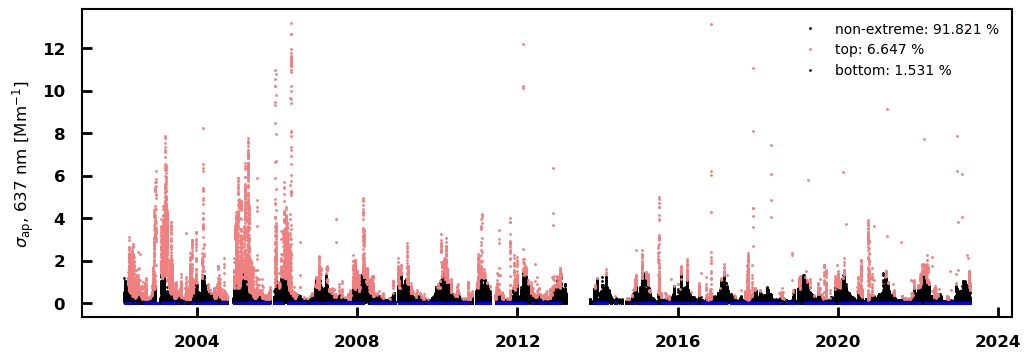

Save as: C:\Users\DominicHeslinRees\Documents\Analysis\HYSPLIT\extremes\df_abs637_extremes_99.dat
Index(['percentile_99', 'percentile_98', 'percentile_97', 'percentile_96',
       'percentile_95', 'percentile_90', 'percentile_80', 'percentile_70',
       'percentile_60', 'percentile_50', 'percentile_1', 'percentile_2',
       'percentile_3', 'percentile_4', 'percentile_5', 'percentile_10',
       'percentile_20', 'percentile_30', 'percentile_40'],
      dtype='object')
High outliers (proportion)
0.08657987401972475
Low outliers (proportion)
0.051430254906637114


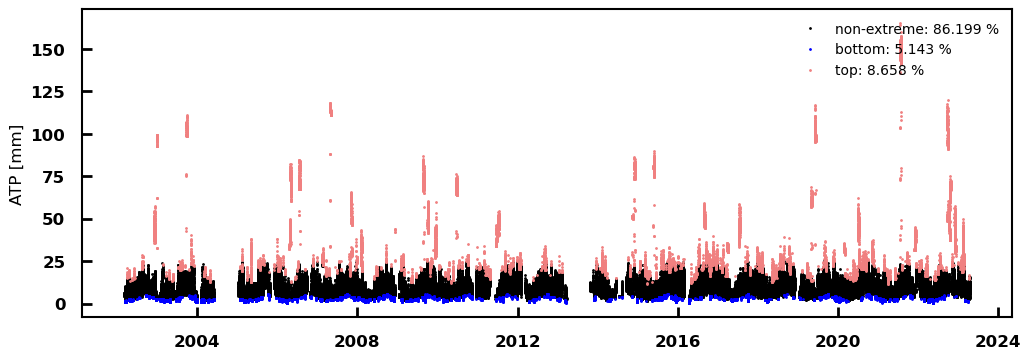

Save as: C:\Users\DominicHeslinRees\Documents\Analysis\HYSPLIT\extremes\df_tp_era5_extremes_99.dat
Index(['percentile_99', 'percentile_98', 'percentile_97', 'percentile_96',
       'percentile_95', 'percentile_90', 'percentile_80', 'percentile_70',
       'percentile_60', 'percentile_50', 'percentile_1', 'percentile_2',
       'percentile_3', 'percentile_4', 'percentile_5', 'percentile_10',
       'percentile_20', 'percentile_30', 'percentile_40'],
      dtype='object')
High outliers (proportion)
0.02980633201619591
Low outliers (proportion)
0.0


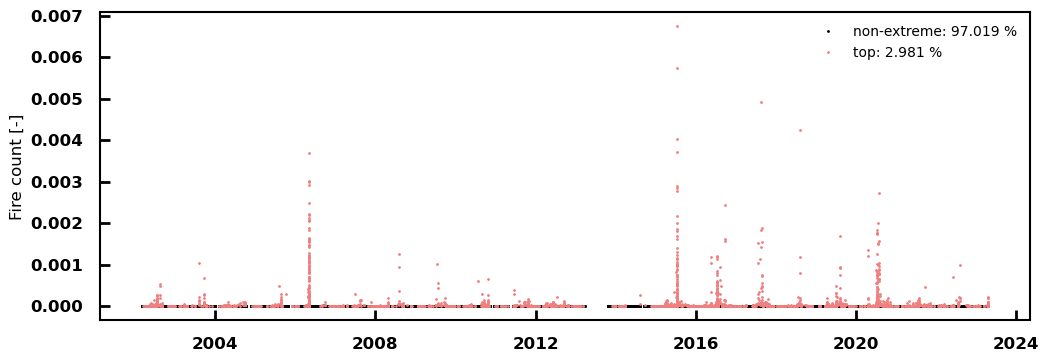

Save as: C:\Users\DominicHeslinRees\Documents\Analysis\HYSPLIT\extremes\df_BC_GFED_extremes_99.dat


In [13]:
variables = ['abs637', var_rain, var_fire]
DFs = [df_abs637, df_era5_GDAS, df_GFED]

ylabels = ['$\sigma_{\mathrm{ap}}$, 637 nm [Mm$^{-1}$]', 'ATP [mm]', 'Fire count [-]']

dict_var_to_ylabel = dict(zip(variables, ylabels))

var='abs637'
percentile = 99

for var, df in zip(variables, DFs):
    df = extremes.add_datetime_columns_and_resample_D(df)
    df_percentiles = create_df_of_percentiles(df, top_percentiles=[99,98,97,96,95,90,80,70,60,50], 
                                                  var=var)
    df  = quantiles_df(df, df_percentiles, var=var, percentile=percentile)
    df = extremes.add_outlier(df, var=var)
    df = df[[var,'timestamp','outlier']].copy()
    
    fig = extremes.plot_outliers(df, var, datetime_col='timestamp',
                                ylabel=dict_var_to_ylabel[var])
    
    df = df.set_index('timestamp')
    
    extremes.save_df(df, path=r'C:\Users\DominicHeslinRees\Documents\Analysis\HYSPLIT\extremes', 
              name='df_'+str(var)+'_extremes_'+str(percentile))

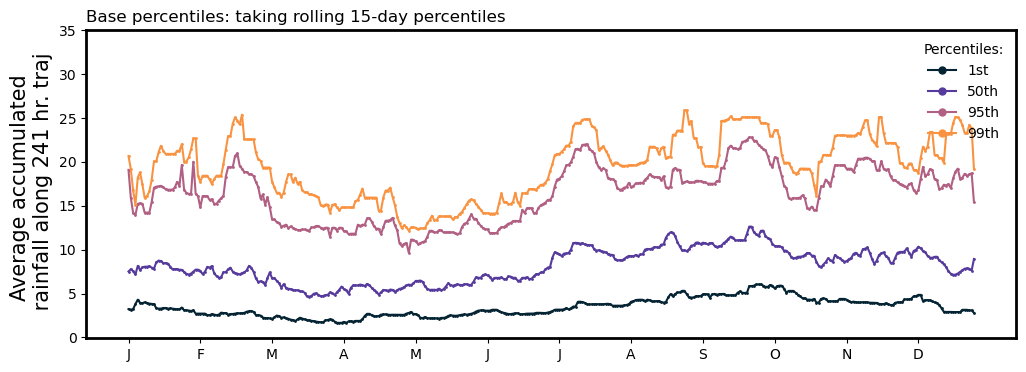

['C:\\Users\\DominicHeslinRees\\Pictures\\black_carbon\\final_plots']
make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\\percentiles_extreme_rain.jpeg


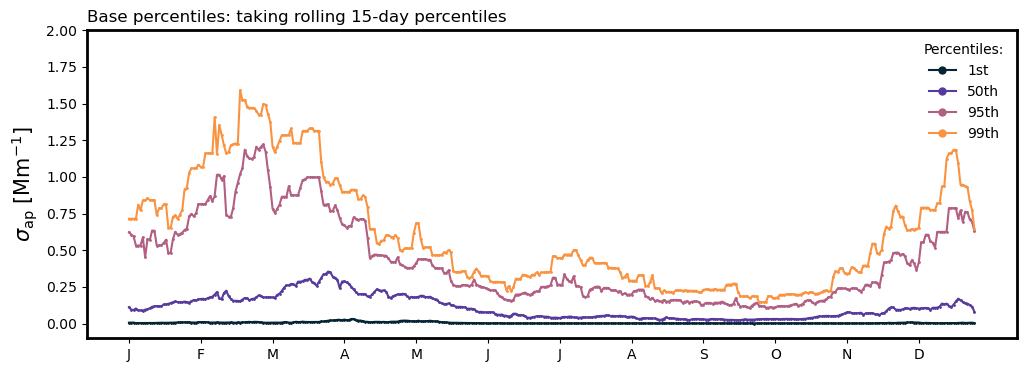

['C:\\Users\\DominicHeslinRees\\Pictures\\black_carbon\\final_plots']
make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\\percentiles_extreme_abs.jpeg


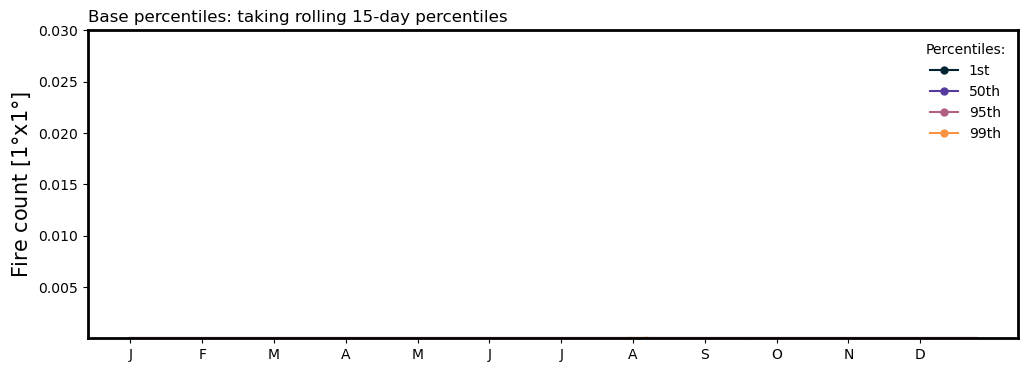

['C:\\Users\\DominicHeslinRees\\Pictures\\black_carbon\\final_plots']
make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\\percentiles_extreme_firecount.jpeg


In [14]:
fig = extremes.plot_percentiles(df_DOY_01_rain, df_DOY_50_rain, df_DOY_95_rain, df_DOY_99_rain, var=var_rain, 
                  ylabel='Average accumulated \n rainfall along 241 hr. traj', ms=1, ymax=35)
extremes.save_plot(fig, name='percentiles_extreme_rain')

fig = extremes.plot_percentiles(df_DOY_01_abs, df_DOY_50_abs, df_DOY_95_abs, df_DOY_99_abs, var='abs637', 
                  ylabel='$\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]', ms=1, ymax=2)
extremes.save_plot(fig, name='percentiles_extreme_abs')

fig = extremes.plot_percentiles(df_DOY_01_fire, df_DOY_50_fire, df_DOY_95_fire, df_DOY_99_fire, var=var_fire, 
                  ylabel='Fire count [1$\degree$x1$\degree$]', ms=1, ymin=10**(-8), ymax=.03)
extremes.save_plot(fig, name='percentiles_extreme_firecount')

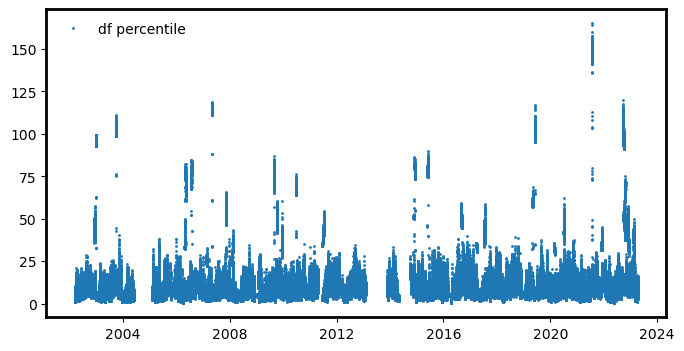

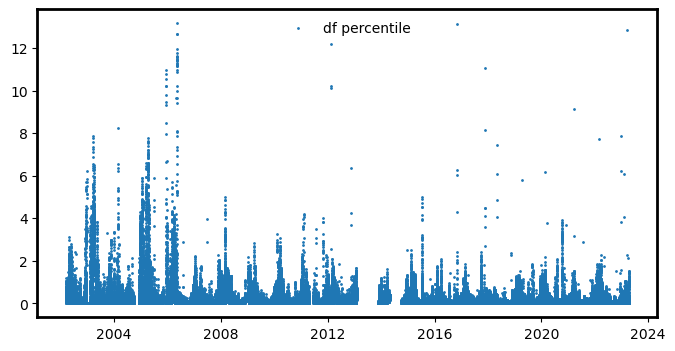

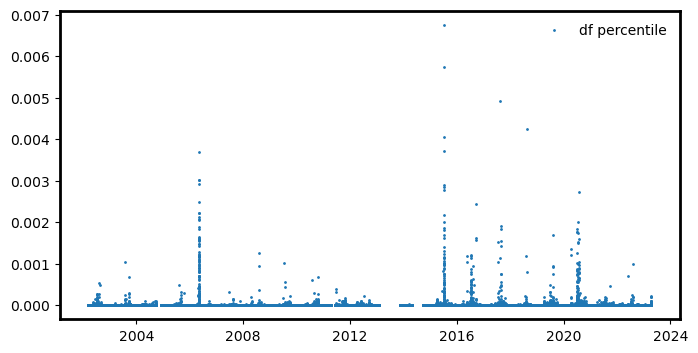

In [15]:
fig = extremes.plot_timeseries(df_percentile_DOY_95_rain, var=var_rain)
fig = extremes.plot_timeseries(df_percentile_DOY_95_abs, var='abs637')
fig = extremes.plot_timeseries(df_percentile_DOY_95_fire, var=var_fire)

In [16]:
df_add_DOY_quantile_D_rain, df_add_DOY_quantile_rain  = extremes.quantiles_df(df_rain, df_rain_D, df_DOY_99_rain, df_DOY_01_rain, var=var_rain)
df_add_DOY_quantile_D_abs, df_add_DOY_quantile_abs = extremes.quantiles_df(df_abs, df_abs_D, df_DOY_99_abs,  df_DOY_01_abs, var='abs637')
df_add_DOY_quantile_D_fire, df_add_DOY_quantile_fire = extremes.quantiles_df(df_fire, df_fire_D, df_DOY_99_fire,  df_DOY_01_fire, var=var_fire)

In [17]:
df_add_DOY_quantile_abs = extremes.add_outlier(df_add_DOY_quantile_abs, var='abs637')
df_add_DOY_quantile_rain = extremes.add_outlier(df_add_DOY_quantile_rain, var=var_rain)
df_add_DOY_quantile_fire = extremes.add_outlier(df_add_DOY_quantile_fire, var=var_fire)

df_add_DOY_quantile_D_abs = extremes.add_outlier(df_add_DOY_quantile_D_abs, var='abs637')
df_add_DOY_quantile_D_rain = extremes.add_outlier(df_add_DOY_quantile_D_rain, var=var_rain)
df_add_DOY_quantile_D_fire = extremes.add_outlier(df_add_DOY_quantile_D_fire, var=var_fire)

High outliers (proportion)
0.06568792433122497
Low outliers (proportion)
0.0150035139299922
High outliers (proportion)
0.08621071349506174
Low outliers (proportion)
0.04999678637996415
High outliers (proportion)
0.029170458473542007
Low outliers (proportion)
0.0
High outliers (proportion)
0.05758008040461678
Low outliers (proportion)
0.0027233821812994424
High outliers (proportion)
0.06341589936454416
Low outliers (proportion)
0.02775256127609908
High outliers (proportion)
0.06964077292180003
Low outliers (proportion)
0.0


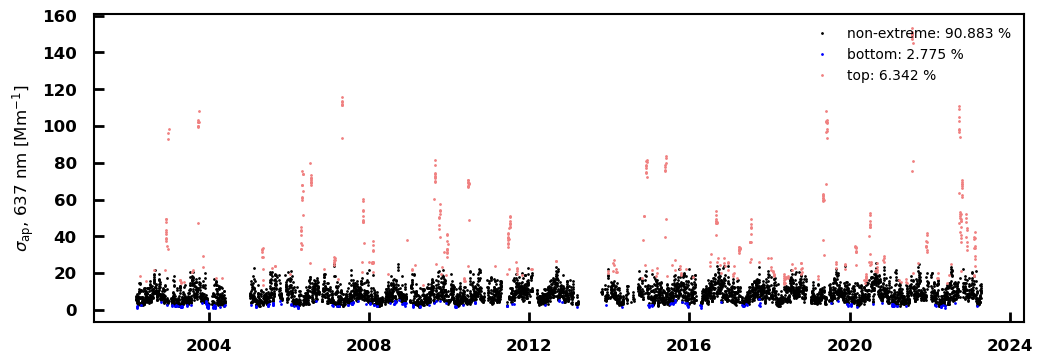

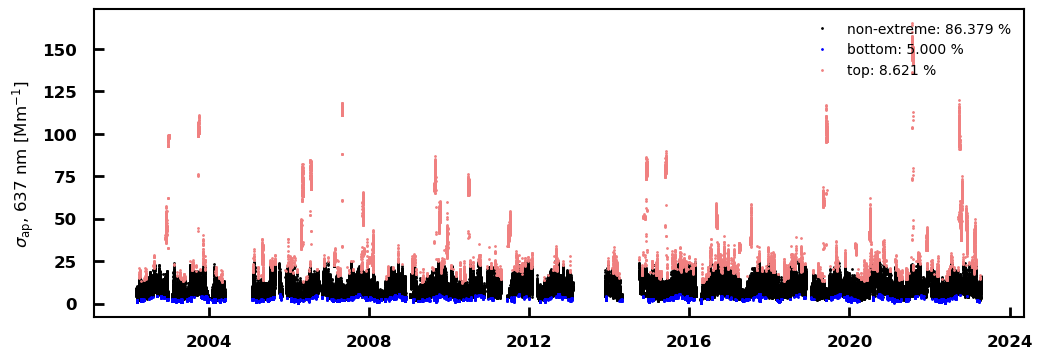

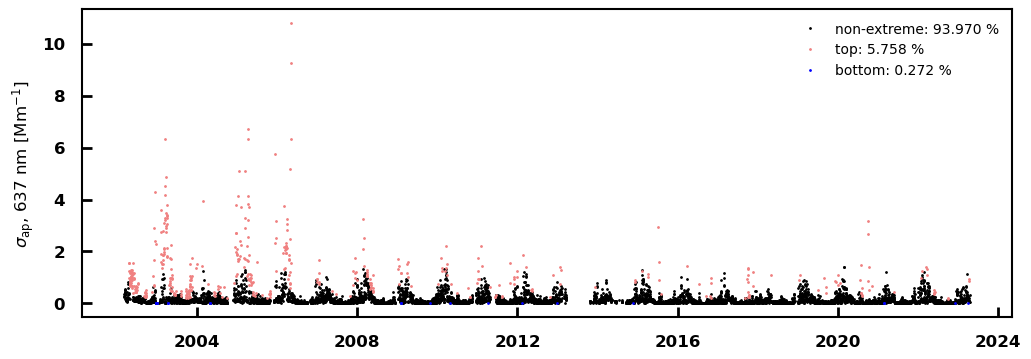

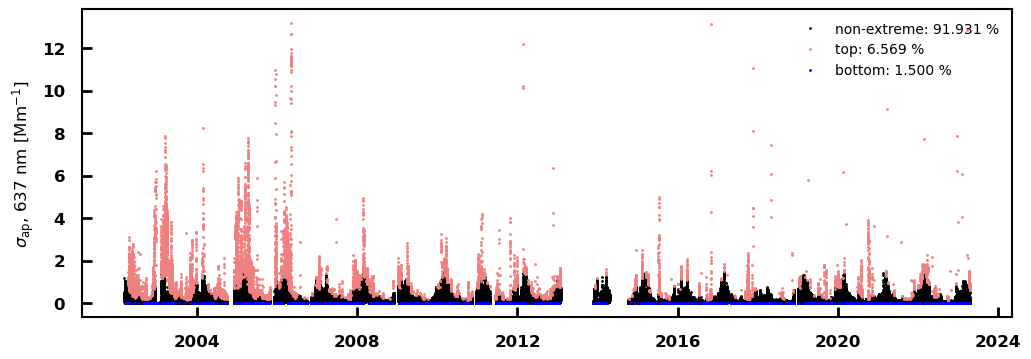

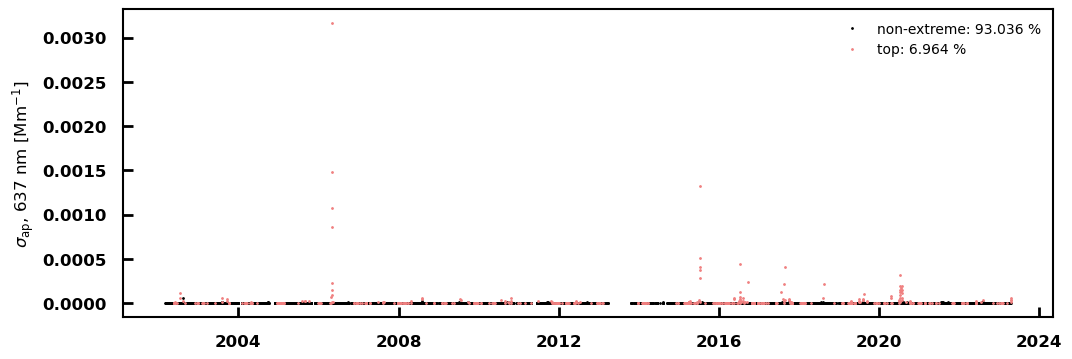

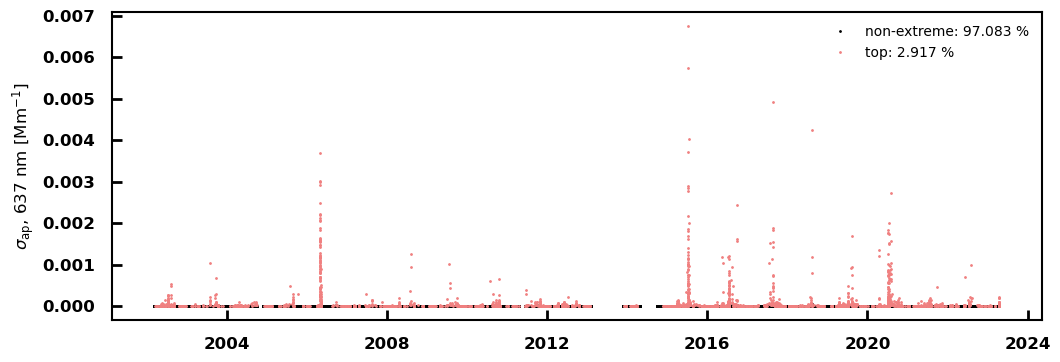

In [18]:
fig = extremes.plot_outliers(df_add_DOY_quantile_D_rain, var=var_rain, datetime_col='datetime')
fig = extremes.plot_outliers(df_add_DOY_quantile_rain, var=var_rain, datetime_col='timestamp')

fig = extremes.plot_outliers(df_add_DOY_quantile_D_abs, var='abs637', datetime_col='datetime')
fig = extremes.plot_outliers(df_add_DOY_quantile_abs, var='abs637', datetime_col='timestamp')

fig = extremes.plot_outliers(df_add_DOY_quantile_D_fire, var=var_fire, datetime_col='datetime')
fig = extremes.plot_outliers(df_add_DOY_quantile_fire, var=var_fire, datetime_col='timestamp')

# Now we have the extreme points: let's subtract them from the timeseries and perform the trend analysis: 

In [19]:
df_add_DOY_quantile_fire = df_add_DOY_quantile_fire.set_index('timestamp')
df_add_DOY_quantile_fire = df_add_DOY_quantile_fire.sort_index()

In [20]:
df_add_DOY_quantile_fire.head(2)

,BC_GFED,day,month,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal,ordinal,DOY,BC_GFED_DOY_quantile_top,BC_GFED_DOY_quantile_bottom,outlier
timestamp,,,,,,,,,,,,,,,,
2002-03-08 14:00:00,0.0,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1,1,67,2.270732e-08,0.0,0
2002-03-08 15:00:00,0.0,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1,1,67,2.270732e-08,0.0,0


In [21]:
extreme_fire_emissions_index = df_add_DOY_quantile_fire[df_add_DOY_quantile_fire['outlier'] == 1].index

In [22]:
def remove_indexes(df, remove_indexes):
    print("old length: "+str(len(df)))
    print("removing: "+str(len(remove_indexes))+" values")
    df_removed = df[~df.index.isin(remove_indexes)].copy()
    print("new length: "+str(len(df)))
    percentage_removed = len(remove_indexes)/len(df_removed)*100 
    print("removed: "+str(len(remove_indexes)/len(df_removed)*100)+' %')
    return df_removed

In [23]:
df_abs_removed = remove_indexes(df_abs637, extreme_fire_emissions_index)

old length: 157263
removing: 4135 values
new length: 157263
removed: 2.700355258345959 %


# Trends: 

In [24]:
month_to_season =  { 1:'SBU',  2:'AHZ', 3:'AHZ',  
                     4:'AHZ',  5:'AHZ', 6:'SUM',  7:'SUM',  8:'SUM', 9:'SUM', 10:'SBU', 
                     11:'SBU', 12:'SBU'}                     
abb_to_name = { 'SBU':'Slow build up', 'AHZ':'Arctic Haze', 'SUM':'Summer/Clean'}
name_to_abb = {'Slow build up':'SBU','Arctic Haze': 'AHZ', 'Summer/Clean':'SUM'}

def add_year_month_ordinal(df):   
    df['timestamp'] = pd.to_datetime(df.index)
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year    
    df['year_num'] = df['year'] - df['year'].iloc[0]
    df['month_ordinal'] = df['year_num']*12 + df['month']
    df['year_num'] = df['year_num'] + 1
    return df
    
def create_month_season_numbers(df, full_season_to_season_num=None):
    start_year = df.index.year[0]
    end_year = df.index.year[-1]
    number_years = end_year - start_year #len(df.index.year.unique())+1        
    df.loc[:,'month_num'] = df.index.month
    df.loc[:,'year'] = df.index.year        
    df.loc[:,'season_abb'] = df.month_num.map(month_to_season).values
    df['season_name'] = df['season_abb'].map(abb_to_name)      
    df.loc[:, "season_abb_year"] = df["season_abb"].astype(str) + '_' +df.index.year.astype(str)
    #print("Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year")
    df.loc[(df['season_abb'] == 'SBU') & (df['month_num'] == 1),  "season_abb_year"] = df.loc[(df['season_abb'] == 'SBU') & (df['month_num'] == 1),  "season_abb_year"].apply(lambda x: x[:-4]+str(int(x[-4:])-1))
    seasons = df.season_abb_year.unique()
    #print("Number of unique seasons: "+str(len(seasons)))    
    seasons_num = np.arange(1,len(seasons)+1,1)
    season_to_season_num = dict(zip(seasons, seasons_num))
    df.loc[:,'season_ordinal'] = df['season_abb_year'].map(season_to_season_num)    
    df = df.sort_index()
    return df

def convert_season_add_year_to_datetime(season_abb_year):
    year = str(season_abb_year)[-4:]
    season_abb = str(season_abb_year)[:3] 
    if season_abb == 'AHZ':
        start = year+'-02-'+'01'
        stop = year+'-05-'+'31'
    if season_abb == 'SUM':
        start = year+'-06-'+'01'
        stop = year+'-09-'+'30'
    if season_abb == 'SBU':
        start = year+'-10-'+'01'
        stop = str(int(year)+1)+'-01-'+'31'
    start = pd.to_datetime(start)
    stop = pd.to_datetime(stop)
    return start, stop

def mid_datetime_function(a, b):
    return a + (b - a)/2

def add_mid_datetime_using_dictionary(df, season_num_to_season):
    df['season_abb_year'] = df.index.map(season_num_to_season)
    df['start'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[0])
    df['stop'] = df['season_abb_year'].apply(lambda x: convert_season_add_year_to_datetime(x)[1])
    df['mid_datetime'] = df.apply(lambda x: mid_datetime_function(x.start, x.stop), axis=1)
    return df

In [25]:
def thickax(ax, fontsize=12, linewidth=4):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)
    plt.rc('axes', linewidth=linewidth)
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=12, width=4, pad=12, bottom=True, top=False, left=True, right=False)    
    
def fancy(ax, fontsize=20, spines=['top','bottom','left','right'], alpha=0.5):    
    # thickning the axes spines
    for axis in spines:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=alpha)  
    
def sf(sf_num):
    sf = '{0:.'+str(sf_num)+'f}' #2 digits of precision and f is used to represent floating point number.
    return sf

In [26]:
def seasonal_averages(df_abs_2022):
    df_seasons = df_abs_2022.groupby('season_ordinal').mean()['abs637'].to_frame() 
    season_num_to_season = dict(zip(df_abs_2022['season_ordinal'], df_abs_2022['season_abb_year'])) 
    df_seasons = add_mid_datetime_using_dictionary(df_seasons, season_num_to_season)
    df_seasons["season_abb"]=df_seasons["season_abb_year"].apply(lambda x: x[:3])
    return df_seasons

def remove_unwanted_values(df_abs_2022):
    df_abs_2022 = df_abs_2022[['abs637']].copy()    
    df_abs_2022 = df_abs_2022.replace([np.inf, -np.inf], np.nan)
    df_abs_2022 = df_abs_2022.dropna(how='all')
    return df_abs_2022

def add_trend_season(df_seasons, freq=3, c='r', loc=1, alpha=0.05, 
                     xcoord_legend=0.5, ycoord_legend=.95, mscale = 2, fs_legend=10, uncertainty=False, 
                     ax=None):
    ax2 = ax.twiny()
    x = df_seasons.index #intergers  
    y = df_seasons['abs637'].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    #significant figures
    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    
    if uncertainty == True:
        label=str('TS$_{\,\mathrm{seasonal}}$: y = '+str(theil_m)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept))
    if uncertainty == False:
        label=str('TS$_{\,\mathrm{seasonal}}$: y = '+str(theil_m)+' $\,\mathdefault{x}$ +'+str(intecept))
        
    ax2.plot(x, Theil_slope, ls='--', lw=1, c=linecolour,alpha=0.5,
            label=label)
    ax2.fill_between(x, up_slope, lo_slope, alpha=alpha, color=linecolour)
    legend = ax2.legend(numpoints = 1,loc='upper left',bbox_to_anchor=(xcoord_legend, ycoord_legend),
              frameon=False, markerscale=mscale, ncol=1, fontsize=fs_legend)  
    legend.get_title().set_fontsize(fs_legend)
    
    ax2.set_xticklabels('')
    ax2.set_xticks([])
    return ax2

def daily_medians(df_abs_2022):
    df_daily_abs = df_abs_2022.resample('D').median()
    df_daily_abs = df_daily_abs.replace([np.inf, -np.inf], np.nan)
    df_daily_abs = df_daily_abs.dropna(how='all')
    df_daily_abs = df_daily_abs[['abs637']].copy()
    return df_daily_abs

def produce_seasonal_test_daily_ax(df_daily_abs, fs_legend=10, ms=5, freq=365.25, sigfigs=3, linecolour = 'red', 
               ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label = 12, 
               xcoord_legend=0, ycoord_legend=.98, mscale = 2, ymin=-0.1, ymax = 2, 
               alpha=0.2, uncertainty=False, ax=None):    
    
    ax2 = ax.twiny()
    
    #turn to intergers
    df_daily_abs['day'] = df_daily_abs.index
    df_daily_abs['ordinal'] = df_daily_abs['day'].apply(lambda x: x.toordinal())
    df_daily_abs['ordinal'] = df_daily_abs['ordinal'] - df_daily_abs['ordinal'][0] + 1

    date_ints = list(df_daily_abs['ordinal'].values)
    
    x = np.array([x-date_ints[0]+1 for x in date_ints])    
    y = df_daily_abs['abs637'].values    
    
    res = stats.theilslopes(y, x, 0.90)
    Theil_slope = (res[1] + res[0] * x)
    lo_slope = (res[1] + res[2] * x)
    up_slope = (res[1] + res[3] * x)

    theil_m=res[0]
    theil_m = float(theil_m)*(freq)
    lo_m = float(res[2])*(freq)
    up_m = float(res[3])*(freq)

    #significant figures
    sfs = sf(sigfigs)           
    intecept=sfs.format(res[1])
    theil_m=sfs.format(theil_m)
    lo_m=sfs.format(lo_m)
    up_m=sfs.format(up_m) 
    
    if uncertainty == True:
        label=str('TS$_{\,\mathrm{daily}}$: y = '+str(theil_m)+' ('+str(lo_m)+' to '+str(up_m)+')$\,\mathdefault{x}$ +'+str(intecept))
    if uncertainty == False:
        label=str('TS$_{\,\mathrm{daily}}$: y = '+str(theil_m)+' $\,\mathdefault{x}$ +'+str(intecept))
        
    ax2.plot(x, Theil_slope, ls='-', lw=2, c=linecolour, label=label)
    ax2.fill_between(x, up_slope, lo_slope, alpha=alpha, color=linecolour)
    
    ax2.set_xticks([])
    
    legend = ax2.legend(numpoints = 1,loc='upper left',bbox_to_anchor=(xcoord_legend, ycoord_legend),
              frameon=False, markerscale=mscale, ncol=1, fontsize=fs_legend)  
    legend.get_title().set_fontsize(fs_legend)

    return ax

In [27]:
def make_subplot(df_abs, df_seasons, season, dict_season_to_color=None, color=None, daily_color=None,
                 fs_legend=10, fs_label=12, show_trend=True, show_daily=True, ms=5, ax=None):
    
    if (color is None) & (dict_season_to_color is None):
        color='k'
    if color is None:
        color = dict_season_to_color[season] 
        
    #seasonal
    df_seasons_ = df_seasons[df_seasons["season_abb"] == str(season)].copy()
    if show_trend == True:
        add_trend_season(df_seasons_, freq=3, c='r', xcoord_legend=0., ycoord_legend=1.02, 
                         fs_legend=fs_legend, ax=ax)
    ax.plot(df_seasons_['mid_datetime'], df_seasons_['abs637'], 'o', ls=':', ms=ms, c=color)

    #daily
    if show_daily == True:
        df_abs_ = df_abs[df_abs['season_abb'] == str(season)].copy()
        df_abs_daily_ = daily_medians(df_abs_)
        if daily_color is not 'None':
            daily_color = color
        ax.plot(df_abs_daily_.index, df_abs_daily_.abs637, 'o', c=daily_color, ms=1, alpha=0.4)
    
    if show_trend == True:
        produce_seasonal_test_daily_ax(df_abs_daily_, fs_legend=fs_legend, ms=5, freq=365, sigfigs = 3, linecolour = 'r', 
                       ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label=fs_label, 
                       xcoord_legend=0., ycoord_legend=.8, mscale = 2, ymin=-0.1, ymax=2, ax=ax)
    ax.set_ylim(-0, 0.8)
    return ax

def make_subplot_full(df_abs, df_seasons, color='k', fs_legend=10, fs_label=12, 
                      show_trend=True, show_daily=True, ms=5, ax=None):
    #seasonal
    if show_trend == True:
        add_trend_season(df_seasons, freq=3, c='r', xcoord_legend=0., ycoord_legend=.98, 
                         fs_legend=fs_legend, ax=ax)
    ax.plot(df_seasons['mid_datetime'], df_seasons['abs637'], 'o', ls=':', ms=ms, c=color)

    #daily
    if show_daily == True:
        df_abs_daily = daily_medians(df_abs)
        ax.plot(df_abs_daily.index, df_abs_daily.abs637, 'o', c=color, ms=1, alpha=0.4)

    if show_trend == True:
        produce_seasonal_test_daily_ax(df_abs_daily, fs_legend=fs_legend, ms=5, freq=365, sigfigs = 3, linecolour = 'r', 
                       ylabel='$\sigma_{\mathrm{ap}}$', units='[Mm$^{-1}$]', fs_label=fs_label, 
                       xcoord_legend=0., ycoord_legend=.89, mscale = 2, ymin=-0.1, ymax=2, ax=ax)
    ax.set_ylim(-0, 0.8)
    return ax

<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-27-a6a8d6b21d21>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if daily_color is not 'None':


In [28]:
df_abs637 = remove_unwanted_values(df_abs637)
df_abs637 = create_month_season_numbers(df_abs637)
df_seasons = seasonal_averages(df_abs637)

In [29]:
df_abs_removed.head(2)

,abs637
2002-03-08 14:00:00,0.238
2002-03-08 15:00:00,0.082


In [30]:
df_abs_removed = remove_indexes(df_abs637, extreme_fire_emissions_index)
df_abs_removed = remove_unwanted_values(df_abs_removed)
df_abs_removed = create_month_season_numbers(df_abs_removed)
df_seasons_removed = seasonal_averages(df_abs_removed)

old length: 145292
removing: 4135 values
new length: 145292
removed: 2.9293623412228937 %


## Figure S16: 

In [31]:
def impact_of_fires(df_abs, df_seasons, fs_label=15, fs_legend = 15, fs_tick=25, fs_letter = 20,
                    ms=5, freq = 365.25, sigfigs = 3, linecolour = 'red', ylabel='$\sigma_{\mathrm{ap}}$',
                    units='[Mm$^{-1}$]', 
                    dict_season_to_color = dict(zip(['AHZ', 'SBU', 'SUM'], ["#41b6c4", "#2c7fb8", "#253494"])),
                    dict_season_to_ylim = dict(zip(['AHZ', 'SBU', 'SUM'], [1.2, 0.85, 0.25])) ):

    fig = plt.figure(figsize=(20, 8))

    gs = gridspec.GridSpec(ncols=3, nrows=8, hspace = 0.2, wspace = 0.2, top = 1,
                               bottom = 0, left = 0, right = 1)
    #AHZ
    ax = fig.add_subplot(gs[0:3, 0:1])

    season='AHZ'
    ax.text(.01, 1.12, 'a) Arctic Haze', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5) 
    make_subplot(df_abs, df_seasons, season, dict_season_to_color, fs_legend=fs_legend, fs_label=fs_label, 
                 show_trend=False, show_daily=True,  daily_color='None', ms=10, ax=ax)
    make_subplot(df_abs_removed, df_seasons_removed, season, color='r', show_trend=False, show_daily=False,
                 ms=10, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)    

    #SBU
    ax = fig.add_subplot(gs[0:3, 1:2])
    season='SUM'
    thickax(ax, fontsize=fs_label, linewidth=1)
    ax.text(.01, 1.12, 'b) Summer', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_label, spines=['top','bottom','left','right'], alpha=0.5) 
    make_subplot(df_abs, df_seasons, season, dict_season_to_color, fs_legend=fs_legend, fs_label=fs_label, 
                 show_trend=False, show_daily=True,  daily_color='None', ms=10, ax=ax)
    make_subplot(df_abs_removed, df_seasons_removed, season, color='r', show_trend=False, show_daily=False,
                 ms=10, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)  


    #SUM
    ax = fig.add_subplot(gs[0:3, 2:3])
    season='SBU'
    thickax(ax, fontsize=fs_label, linewidth=1)
    ax.text(.01, 1.12, 'c) Slow build-up', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_label, spines=['top','bottom','left','right'], alpha=0.5) 
    #ax.set_xticklabels([''])
    make_subplot(df_abs, df_seasons, season, dict_season_to_color, fs_legend=fs_legend, fs_label=fs_label,
                 show_trend=False, show_daily=True, daily_color='None', ms=10, ax=ax)
    make_subplot(df_abs_removed, df_seasons_removed, season, color='r', show_trend=False, show_daily=False,
                 ms=10, ax=ax)
    ax.set_ylim(0, dict_season_to_ylim[season])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    #thickax(ax, fontsize=fs_label, linewidth=1)
    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)  


    #FULL
    ax = fig.add_subplot(gs[4:8, 0:3])
    thickax(ax, fontsize=fs_label, linewidth=1)
    ax.text(.01, 1.12, 'd) All seasons', ha='left', va='top', transform=ax.transAxes, fontsize=fs_letter)
    fancy(ax, fontsize=fs_label, spines=['top','bottom','left','right'], alpha=0.5) 
    make_subplot_full(df_abs, df_seasons, show_trend=False, show_daily=False, fs_legend=fs_legend, fs_label=fs_label,
                       ms=10, ax=ax)
    make_subplot_full(df_abs_removed, df_seasons_removed, color='r',
                      show_trend=False, show_daily=False, fs_legend=fs_legend, fs_label=fs_label, ms=10, ax=ax)
    ax.set_ylim(0,1.2)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    fancy(ax, fontsize=fs_tick, spines=['top','bottom','left','right'], alpha=0.5)  

    fig.text(-0.08, 0.5, ylabel+' '+units, ha='center', va='center', rotation='vertical', fontsize=40)

    plt.show()

    return fig 

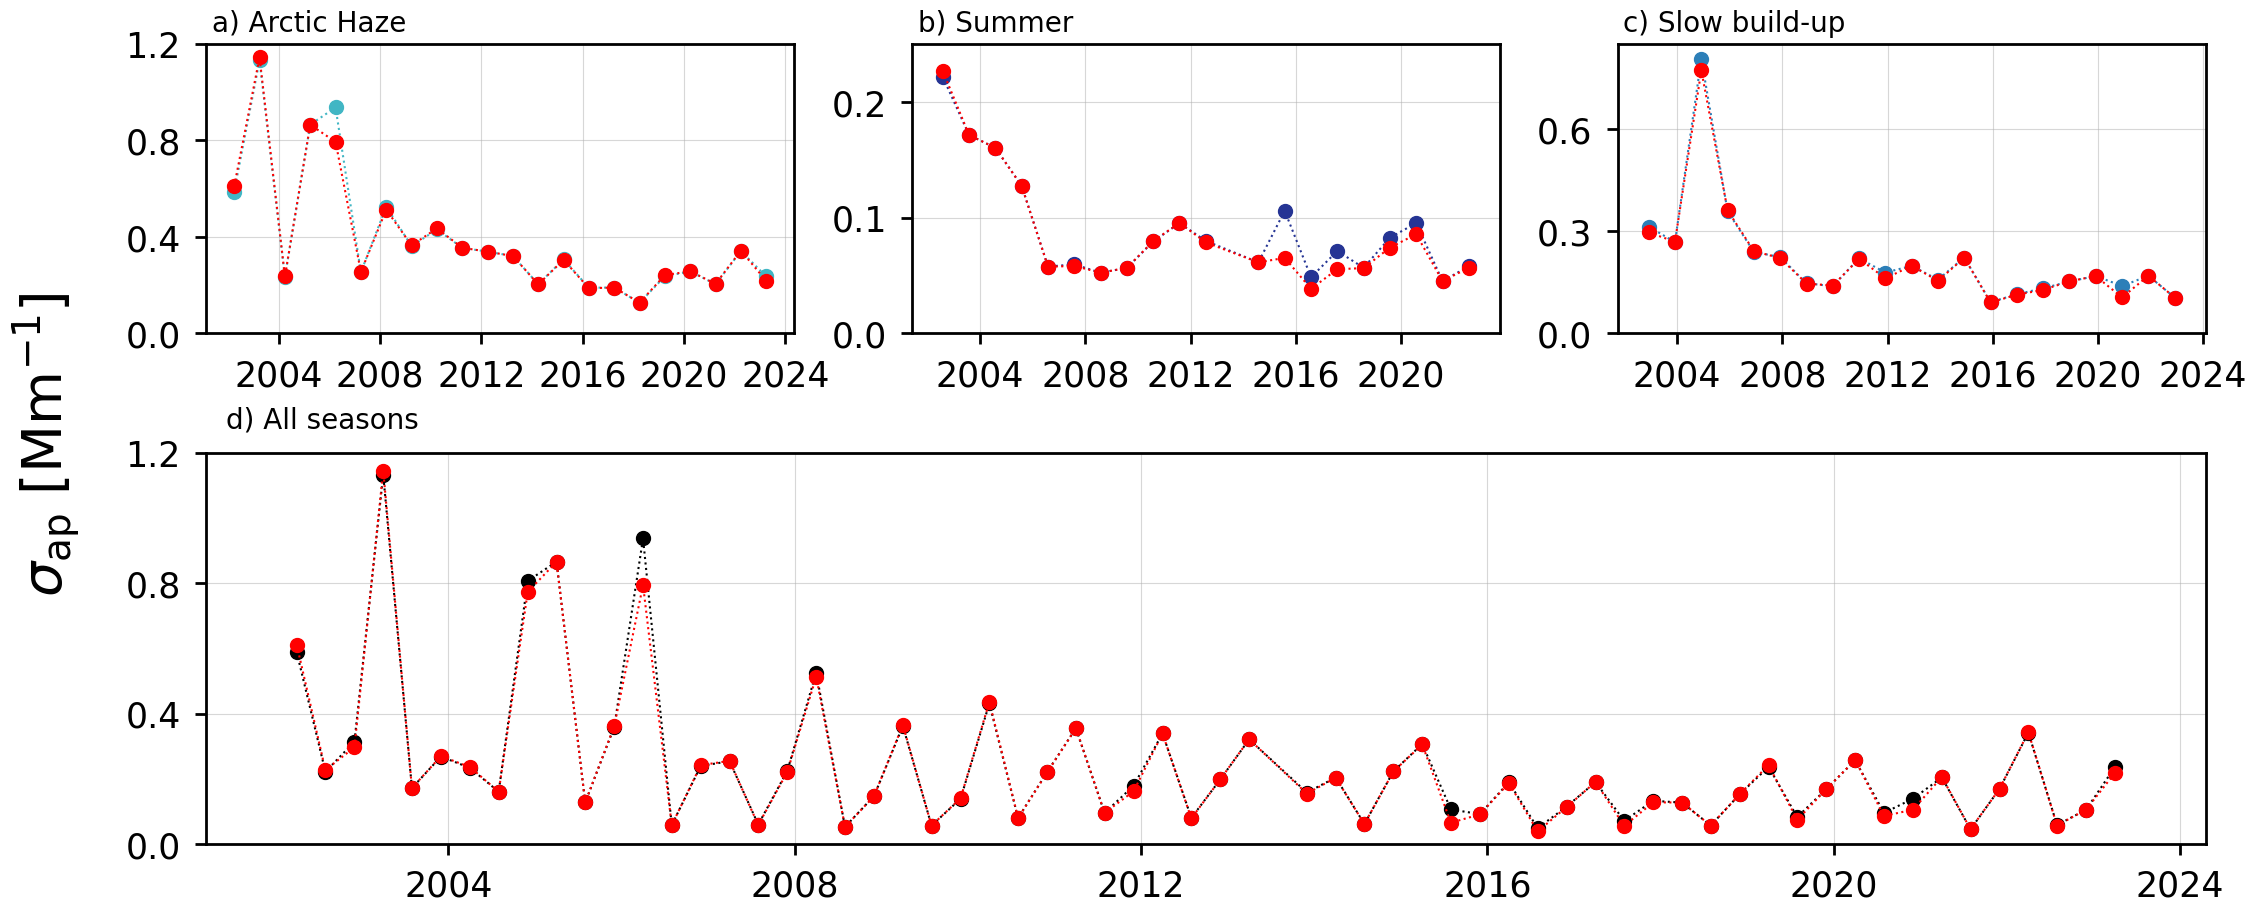

saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\FigureS16.png


In [32]:
fig = impact_of_fires(df_abs_removed, df_seasons,)
fu_trends.save_plot(fig, savepath, name='FigureS16', formate='.png')